In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm
import cv2
import numpy as np

In [3]:
sys.path.append('/kaggle/working/notebook/experiment/v2/')

from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

In [4]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest101e'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"
    smooth=300
    
    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
# os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

In [5]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)


In [6]:
def postprocess(preds, process_fn):
    image_len = preds.shape[0]
    for image_n in range(image_len):
        image = preds[image_n, 0]
        image = process_fn(image)
        preds[image_n, 0] = image
    return preds


def inference(exp_name):
    model, dice_score, thresh = load_model("/kaggle/working/notebook/experiment/v2", exp_name)
    cum_pred = []
    cum_true = []
    for i, (images, masks) in tqdm(enumerate(dataloader_valid), total=len(dataloader_valid)):
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            preds = torch.sigmoid(preds).cpu().detach().numpy()
            preds = postprocess(preds, postprocess_before_thresh)
            masks = masks.cpu().detach().numpy()
            cum_pred.append(preds)
            cum_true.append(masks)
    cum_pred = torch.from_numpy(np.concatenate(cum_pred, axis=0))
    cum_true = torch.from_numpy(np.concatenate(cum_true, axis=0))
    cum_pred_flatten = torch.flatten(cum_pred)
    cum_true_flatten = torch.flatten(cum_true)

    dice_score_, thresh_ = calc_optim_thresh(cum_pred_flatten, cum_true_flatten, [round(x * 0.01, 2) for x in range(1, 101, 2)])
    cum_pred_thresh = (cum_pred > thresh_).numpy().astype(np.uint8)
    
    cum_pred_thresh = postprocess(cum_pred_thresh, postprocess_after_thresh)
    dice_score_ = calc_dice_score(cum_pred_thresh, cum_true, thresh_)

    dice_score = round(dice_score, 4)
    dice_score_ = round(dice_score_, 4)
    return exp_name, dice_score, dice_score_, thresh, thresh_

In [7]:
def postprocess_before_thresh(image):

    return image


def postprocess_after_thresh(image):
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # フィルタリングされた輪郭を格納するリスト
    filtered_contours = []

    # 輪郭の面積に基づいてフィルタリングする
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= 1:  # 適切な面積の閾値を設定してください
            filtered_contours.append(contour)

    # 新しい画像を作成し、フィルタリングされた輪郭を描画する
    image = np.zeros_like(image)
    image = cv2.drawContours(image, filtered_contours, -1, 1, thickness=cv2.FILLED)
    return image

In [13]:
results=[]
results.append(inference("model04"))
results.append(inference("model05"))
results.append(inference("model08"))
results.append(inference("model18"))
results

model_arch:  Unet
backbone:  timm-resnest26d


100%|██████████| 58/58 [00:04<00:00, 13.67it/s]


model_arch:  Unet
backbone:  timm-resnest26d


100%|██████████| 58/58 [00:04<00:00, 13.97it/s]


model_arch:  Unet
backbone:  timm-resnest50d


100%|██████████| 58/58 [00:04<00:00, 12.42it/s]


model_arch:  Unet
backbone:  timm-resnest101e


100%|██████████| 58/58 [00:05<00:00, 10.16it/s]


In [14]:
results

[('model04', 0.6475, 0.6475, 0.26, 0.25),
 ('model05', 0.65, 0.6501, 0.46, 0.43),
 ('model08', 0.6514, 0.6515, 0.03, 0.03),
 ('model18', 0.6538, 0.6535, 0.16, 0.17)]

model_arch:  Unet
backbone:  timm-resnest101e
model_arch:  Unet
backbone:  timm-resnest101e
model_arch:  Unet
backbone:  timm-resnest101e
model_arch:  Unet
backbone:  timm-resnest101e
model_arch:  Unet
backbone:  timm-resnest101e
model_arch:  Unet
backbone:  timm-resnest101e


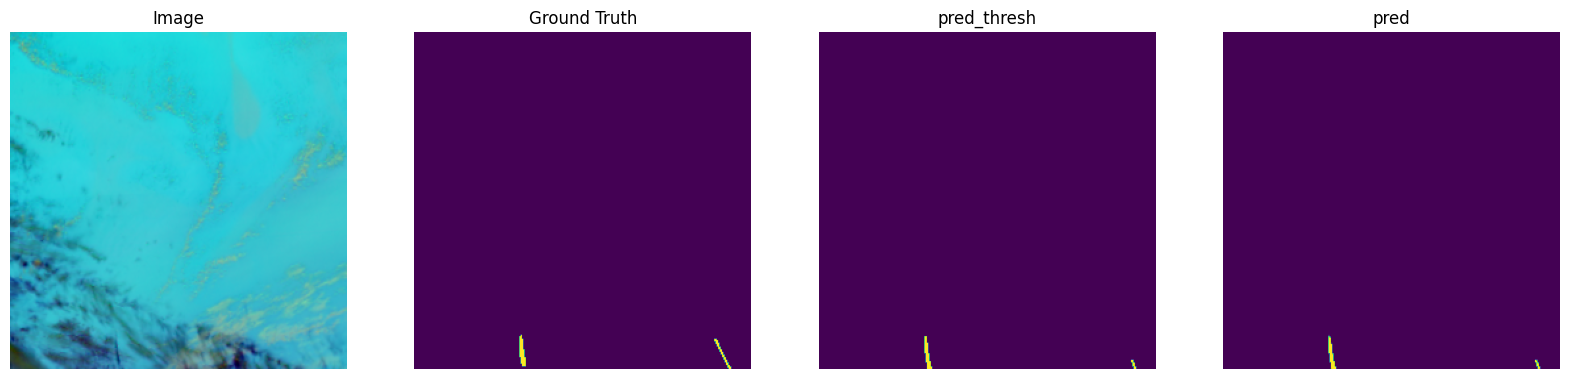

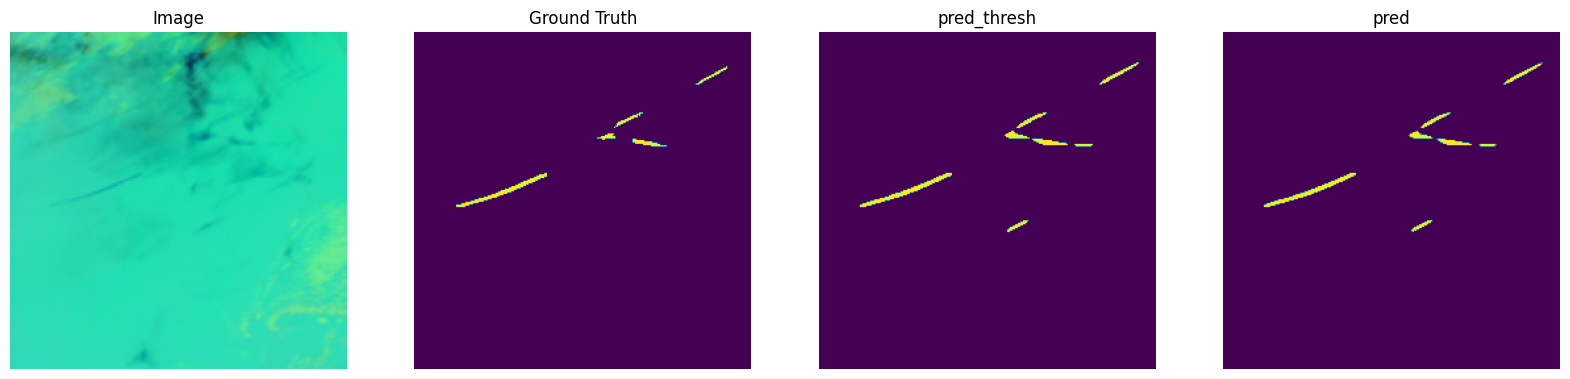

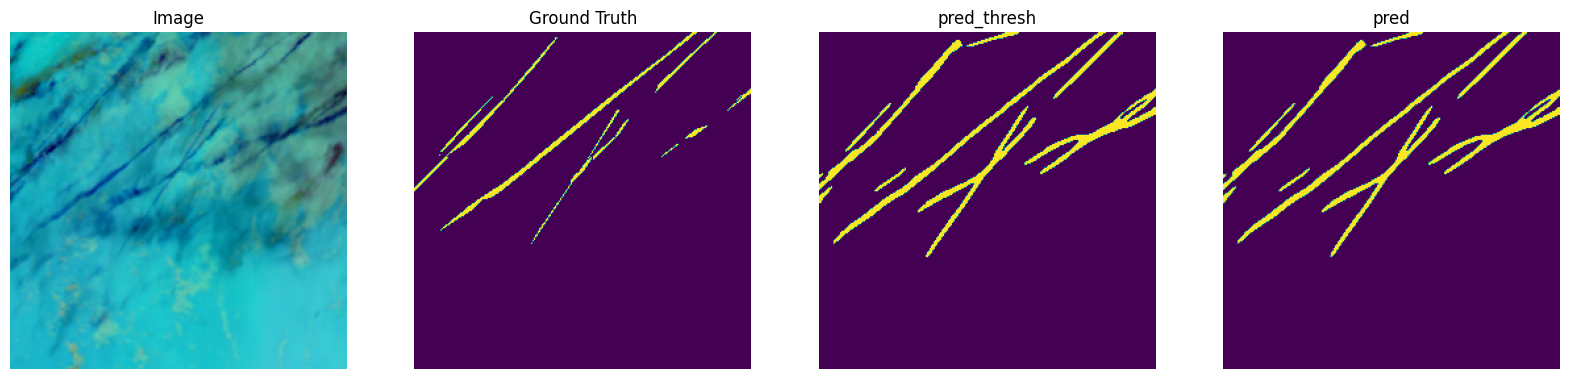

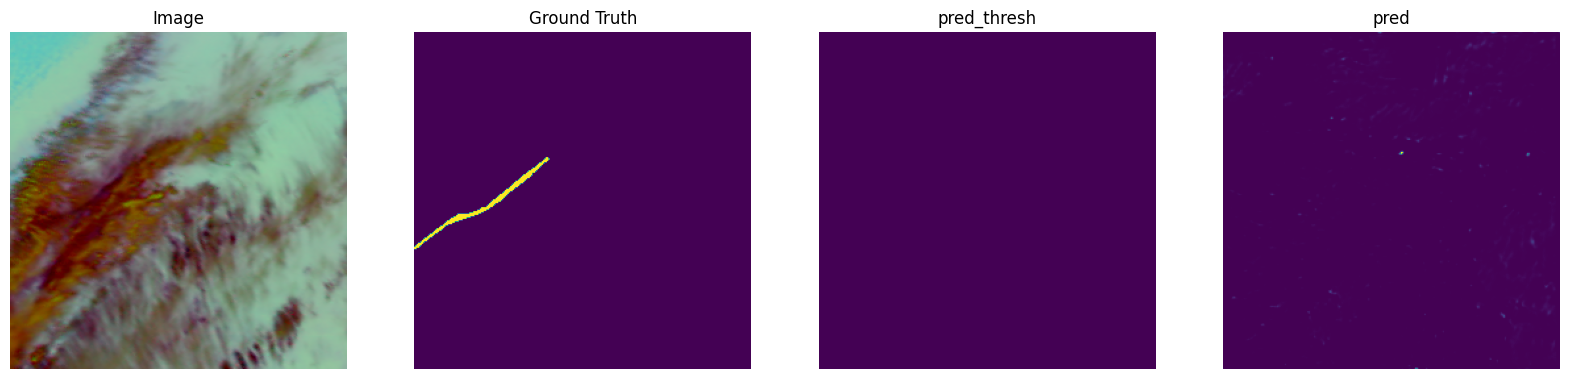

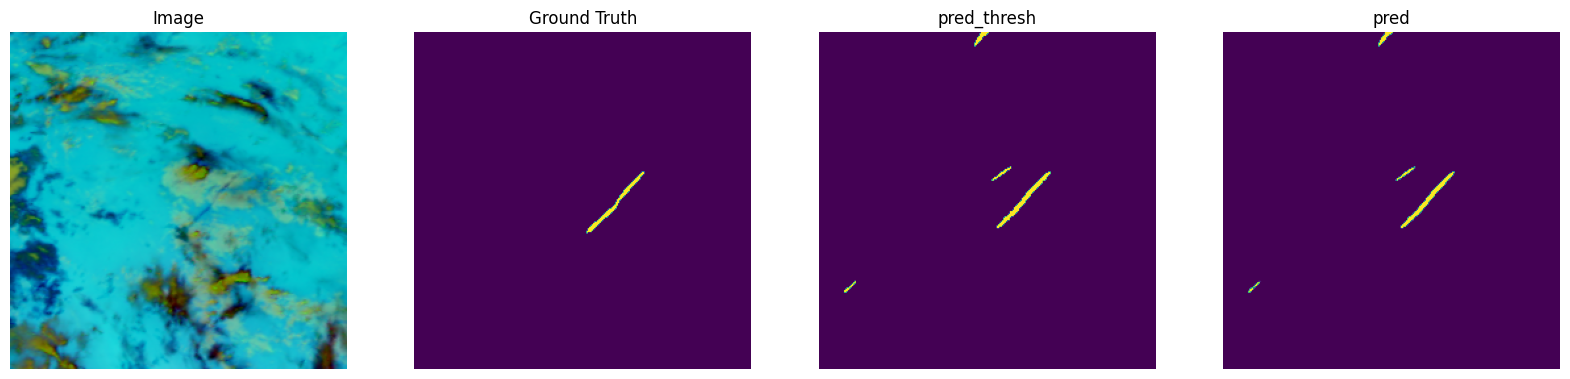

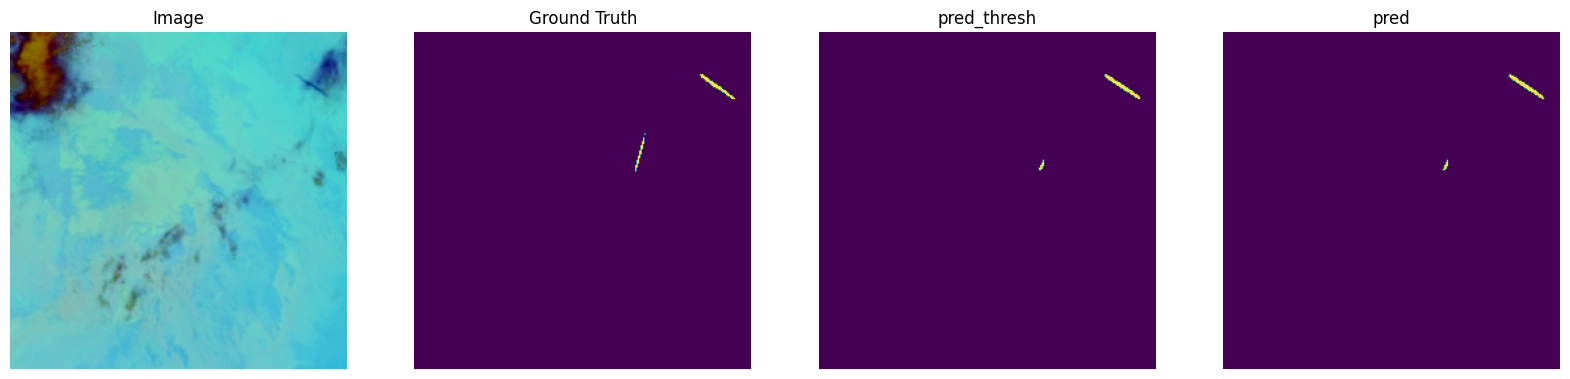

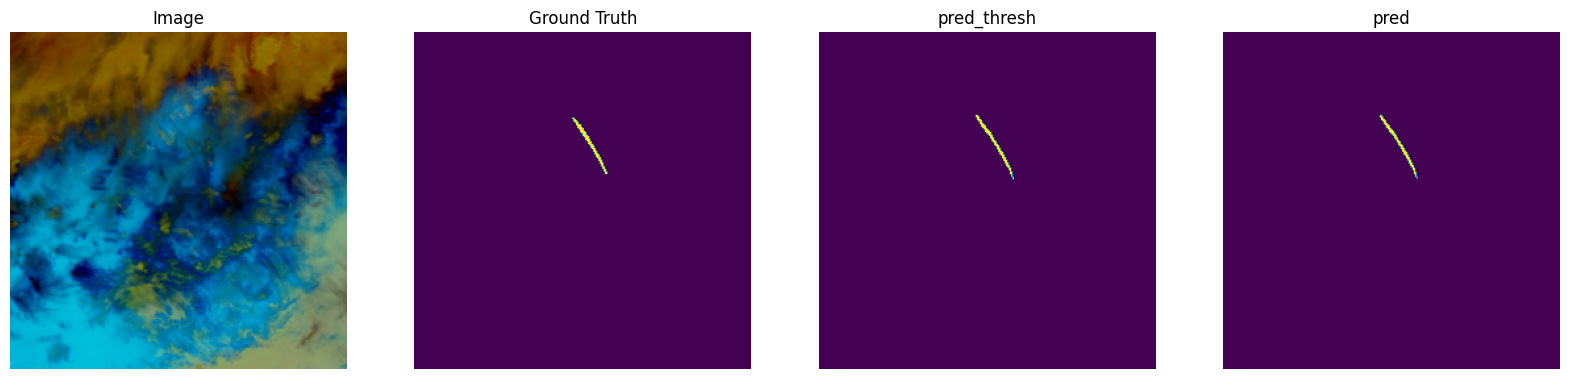

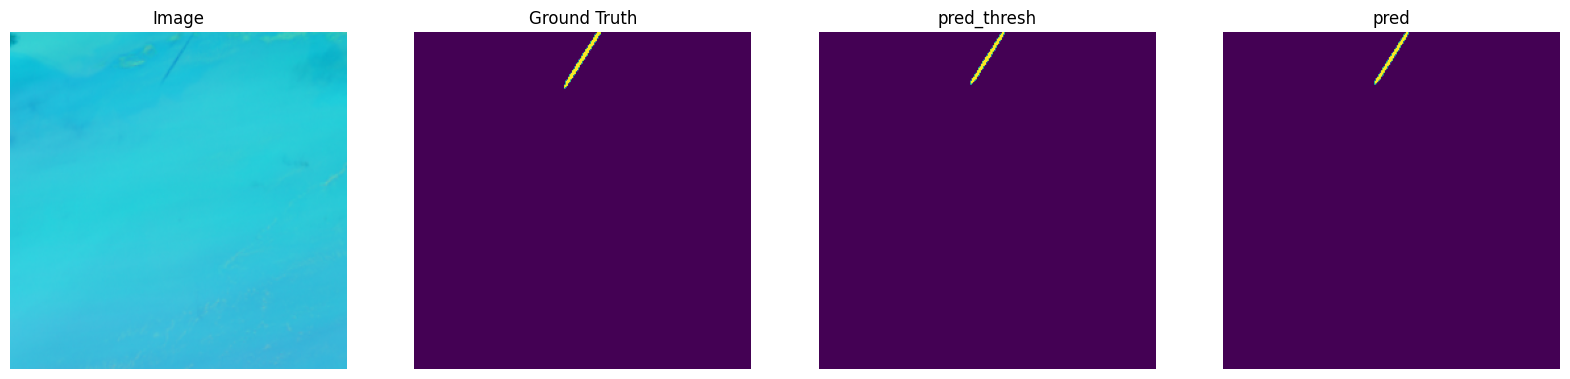

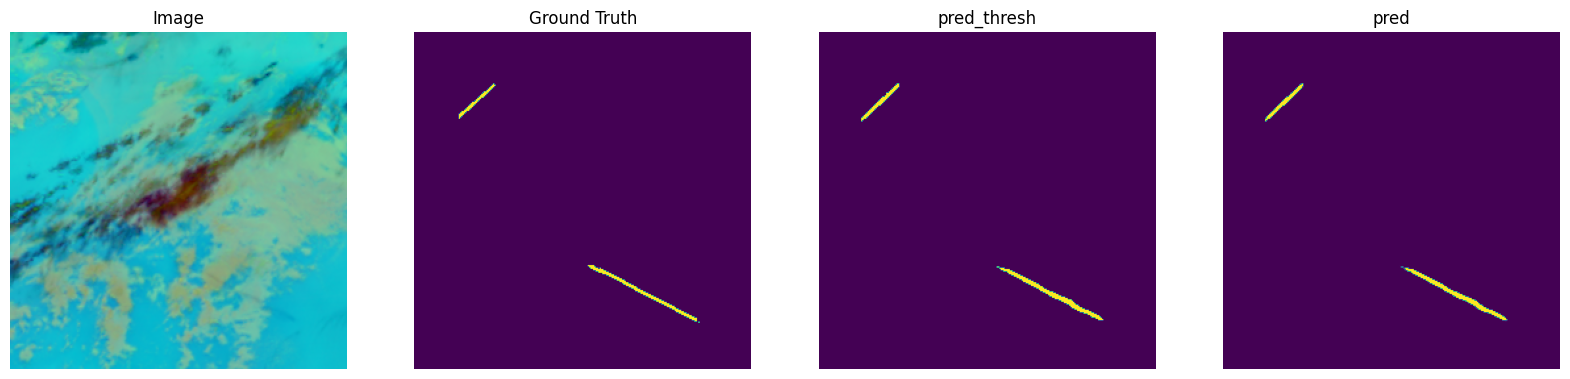

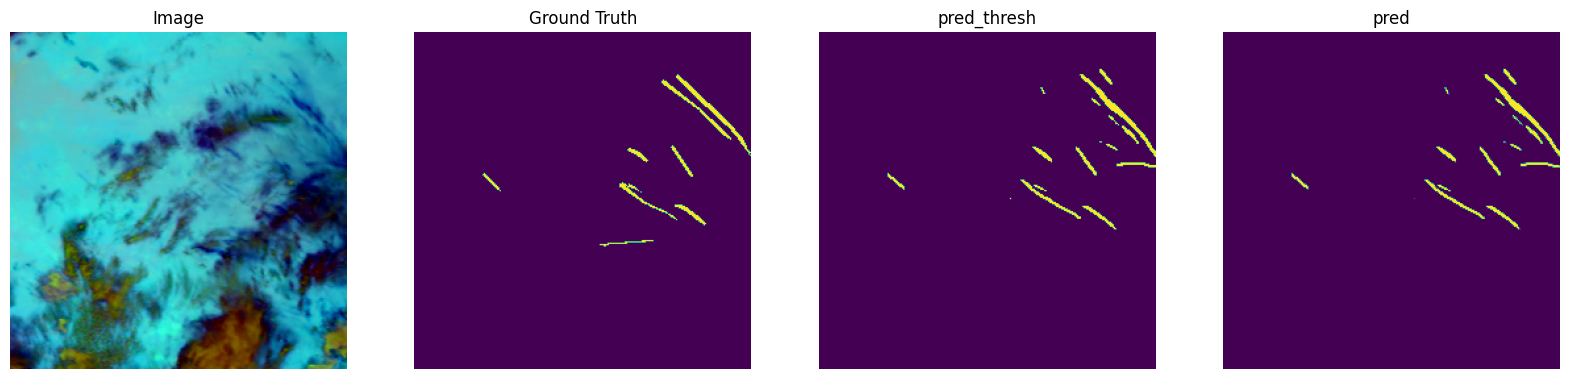

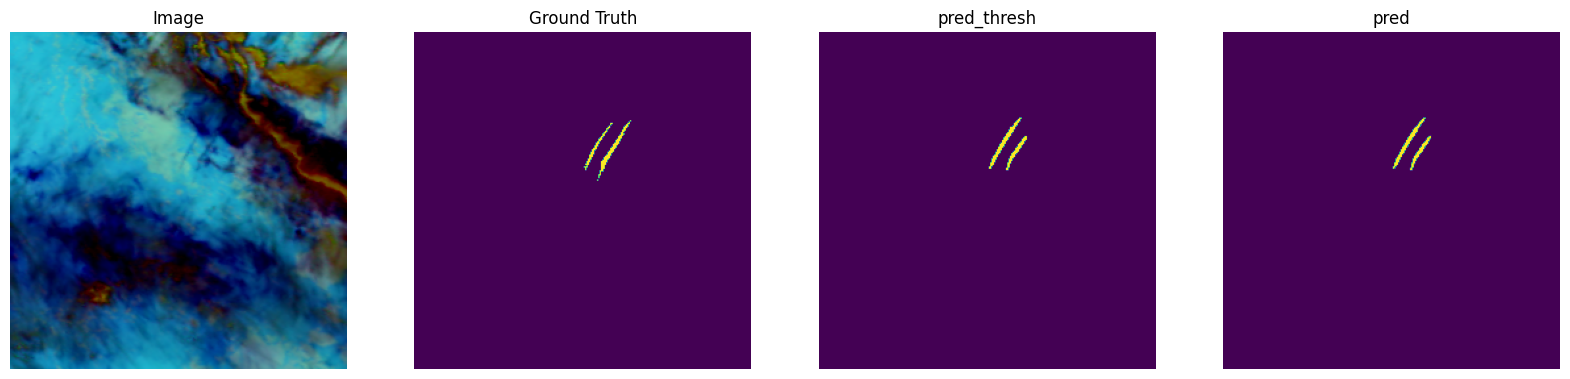

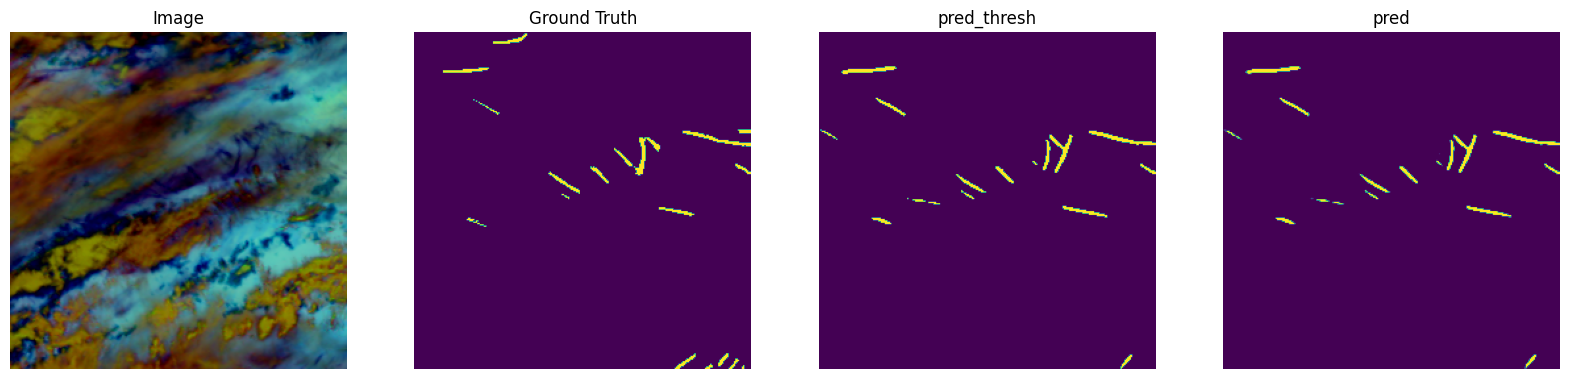

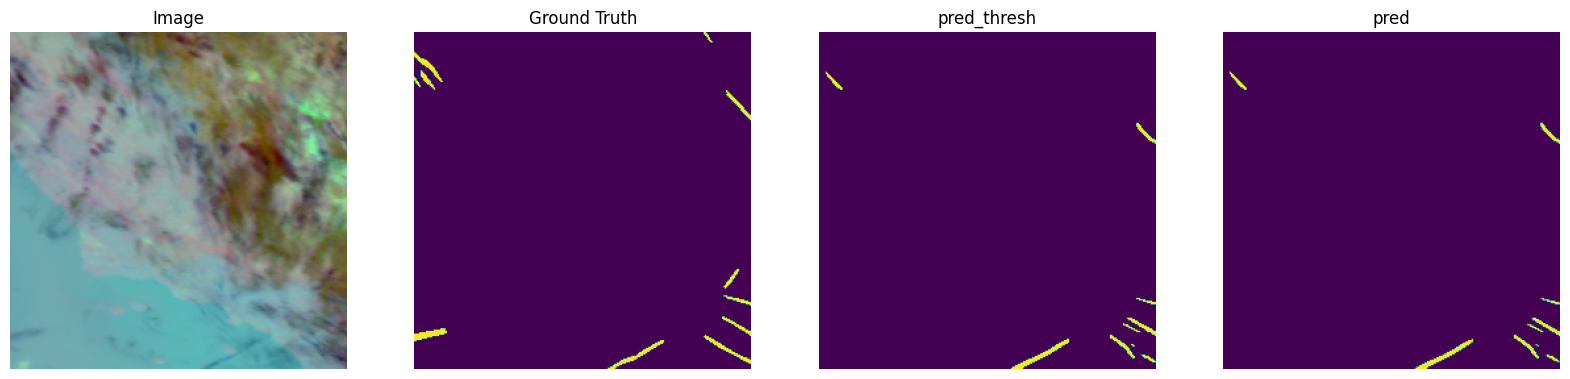

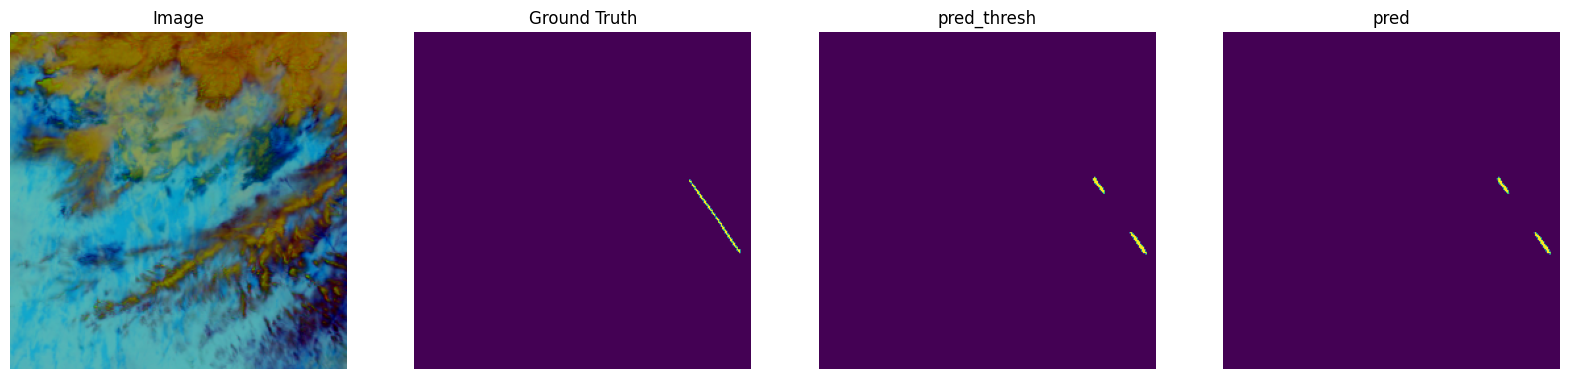

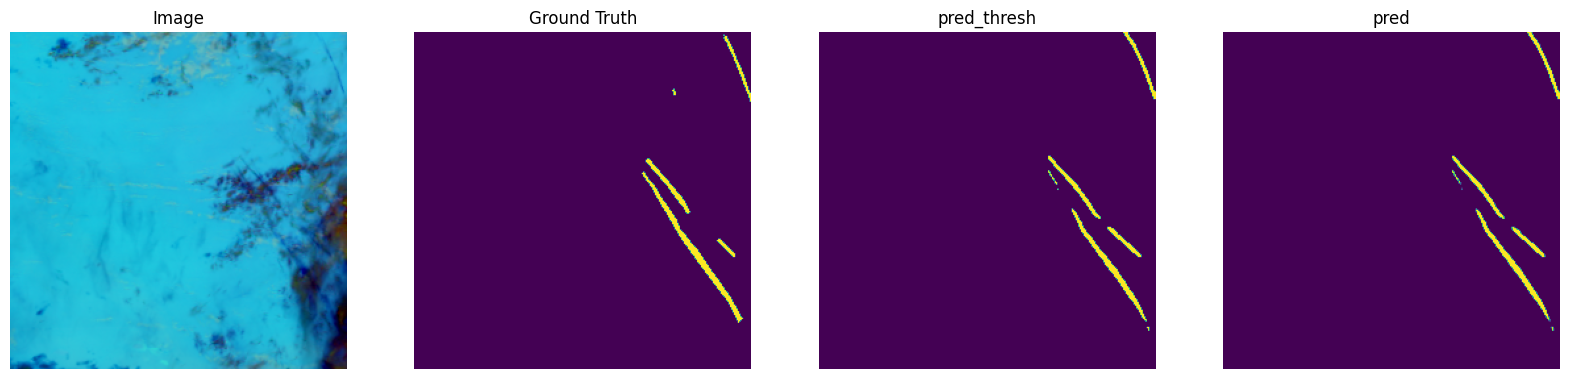

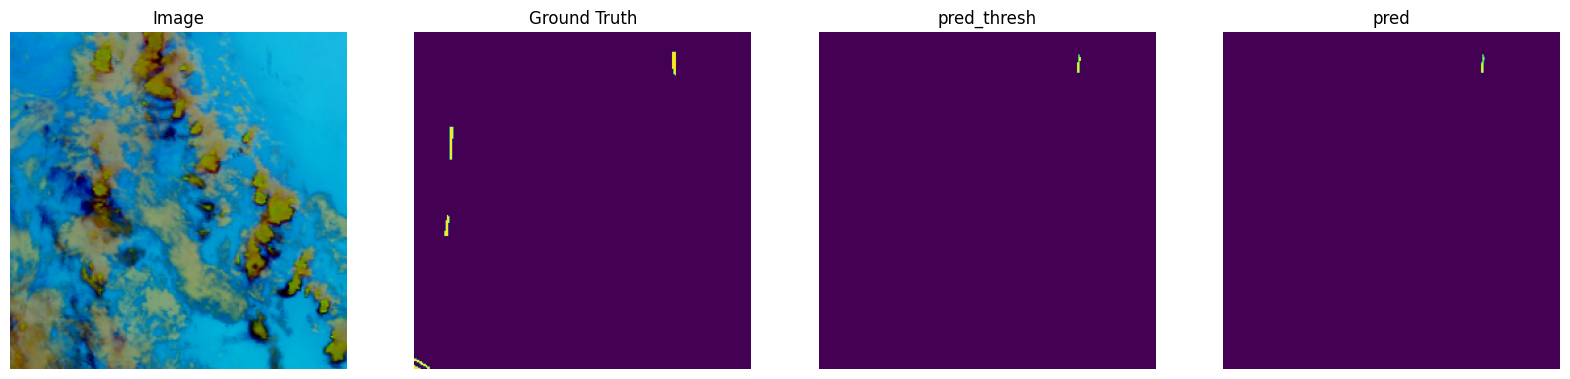

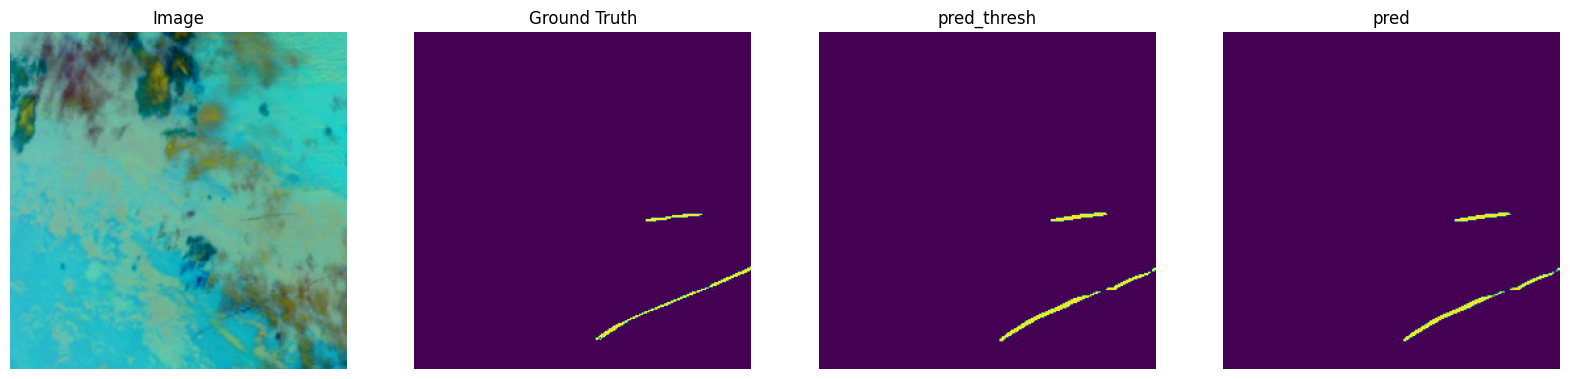

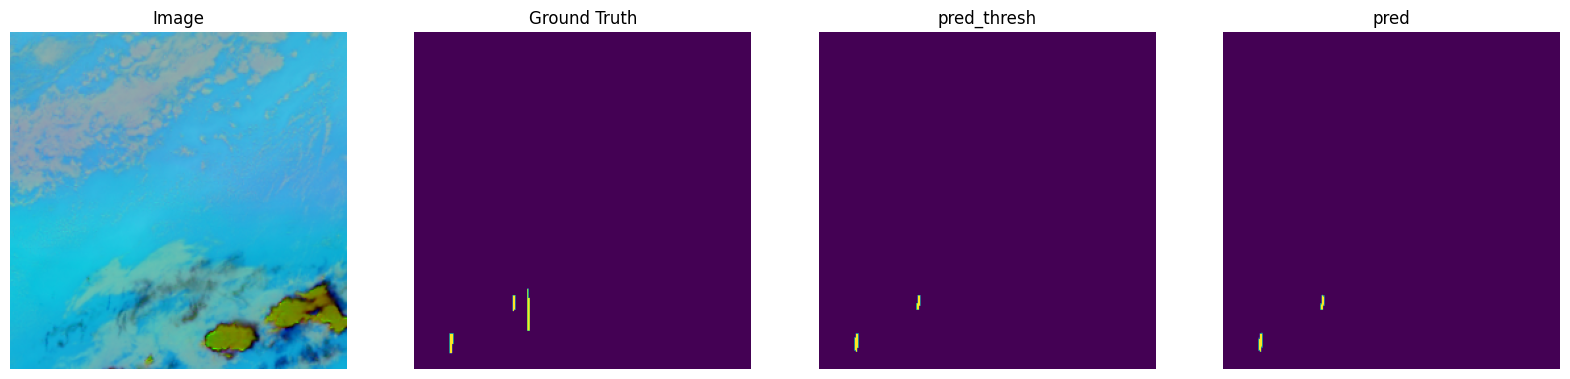

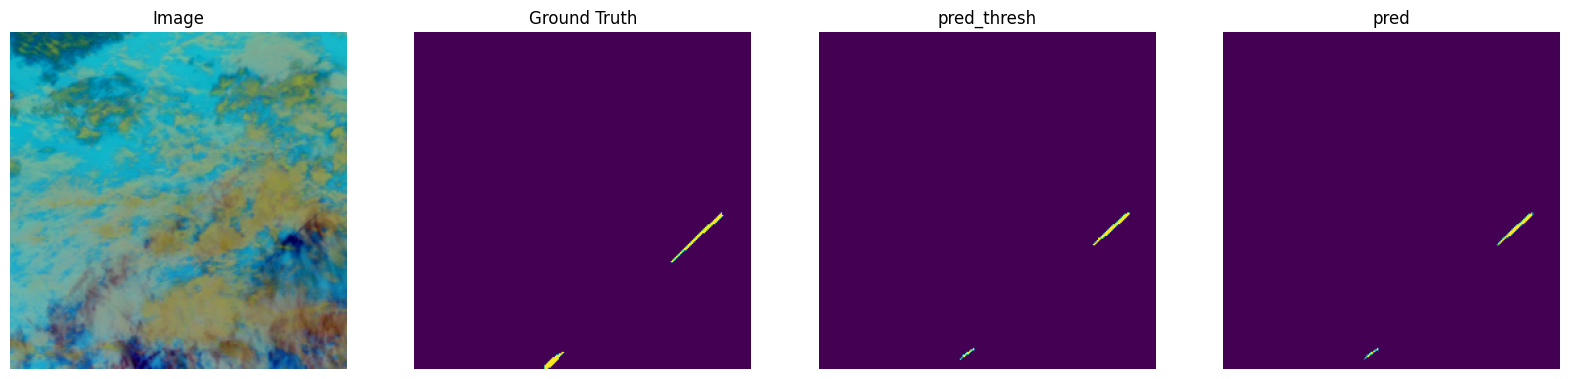

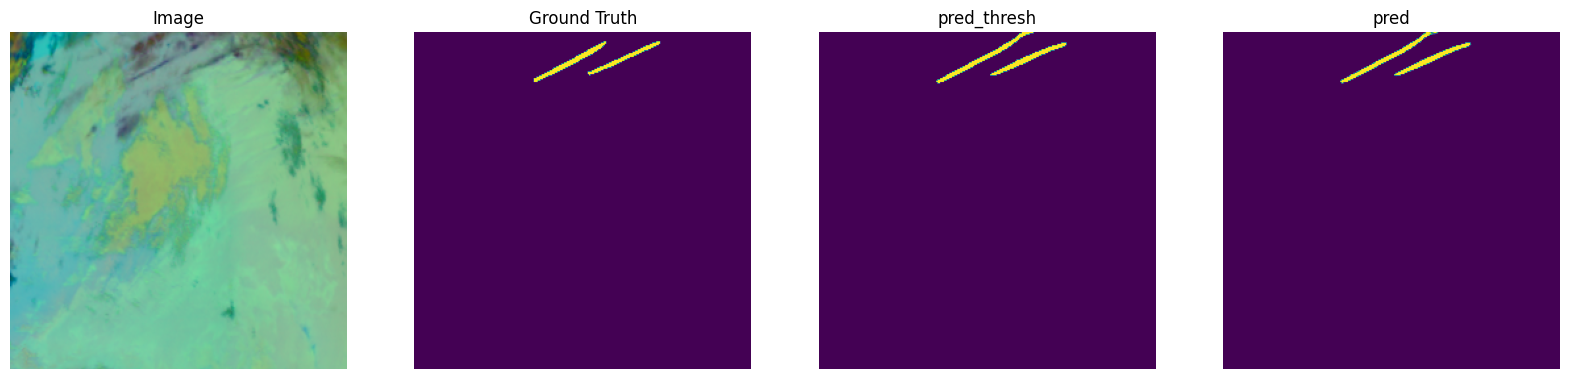

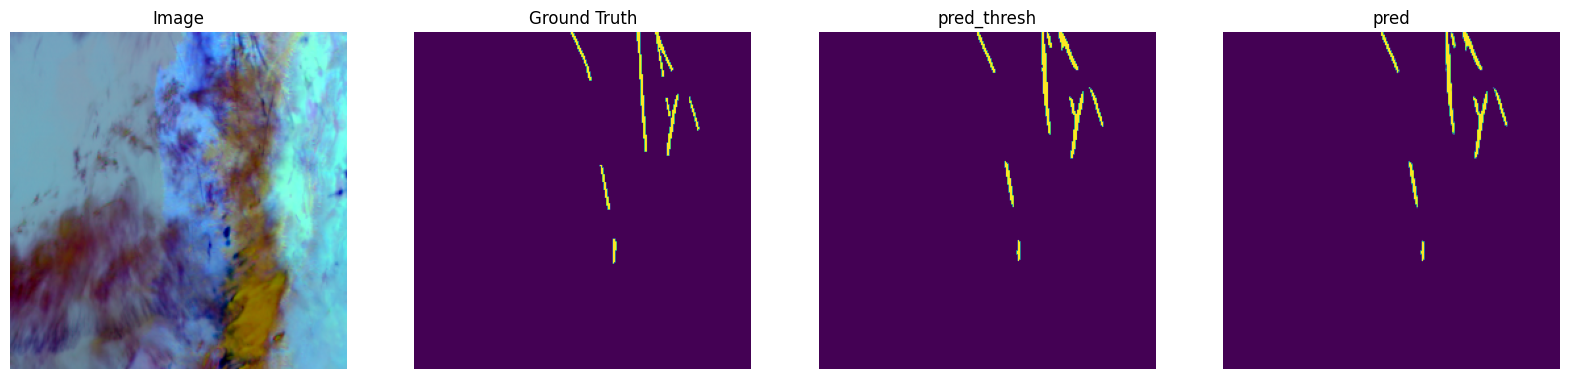

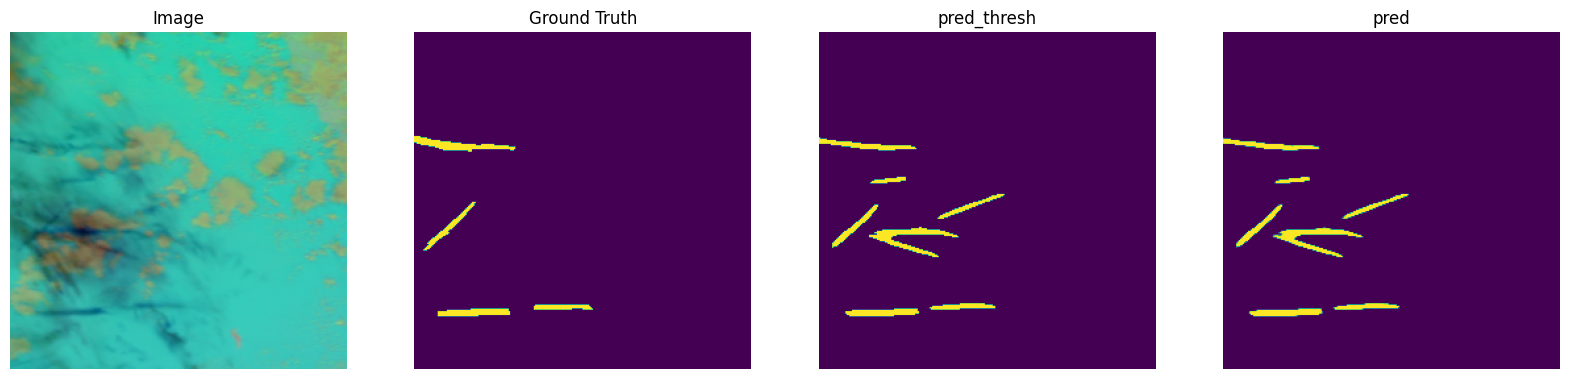

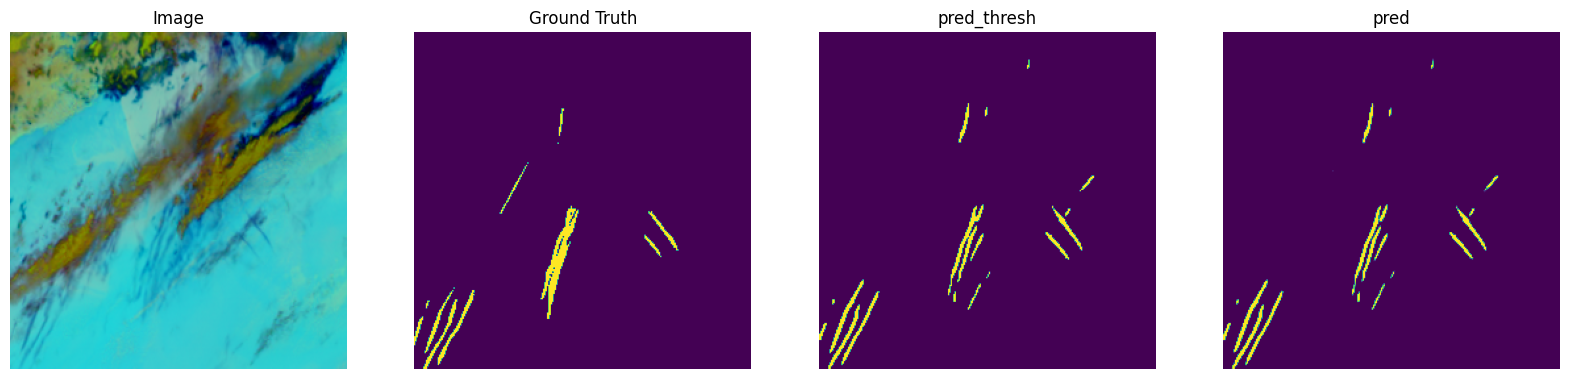

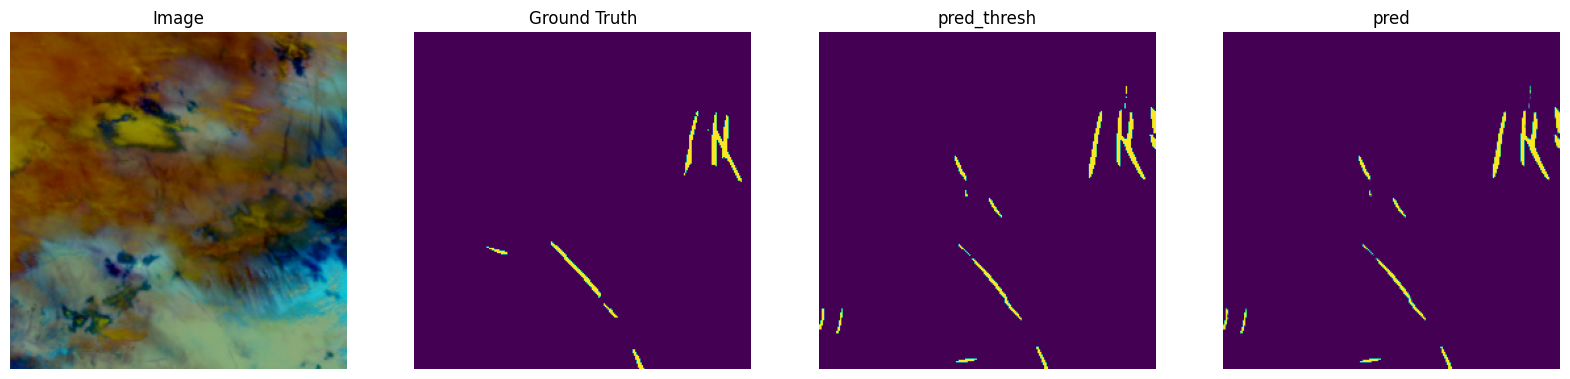

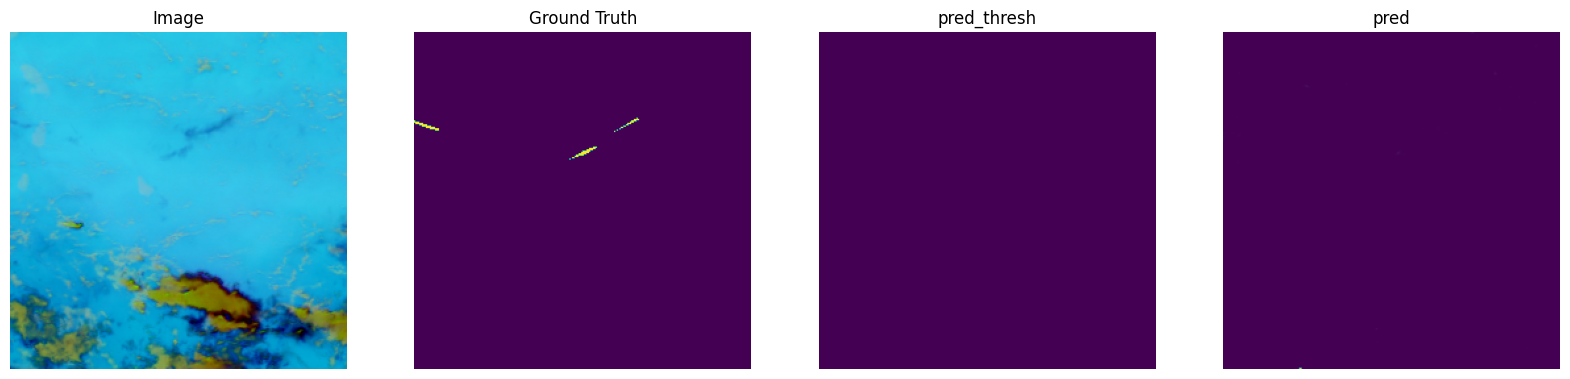

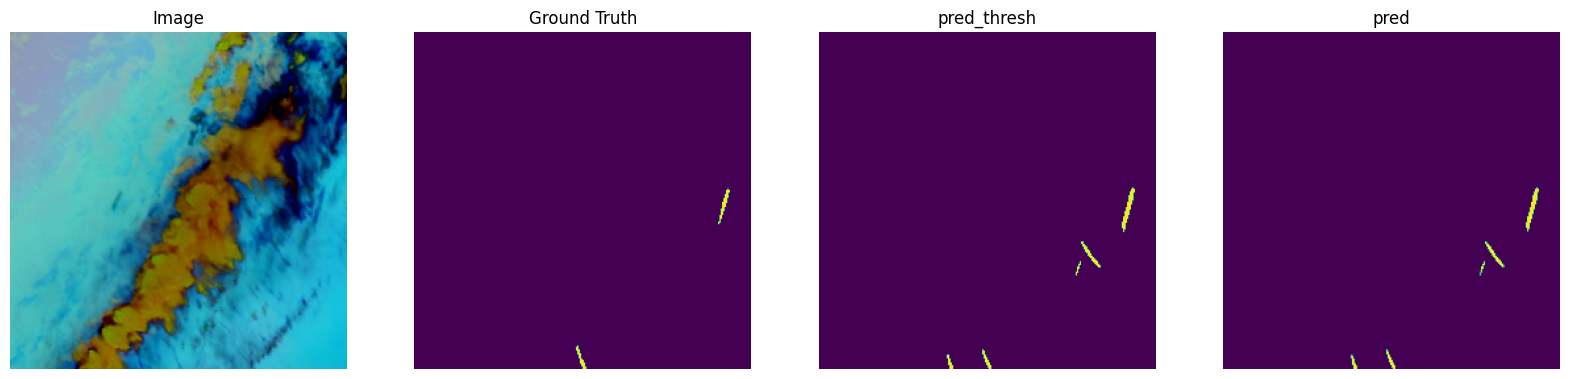

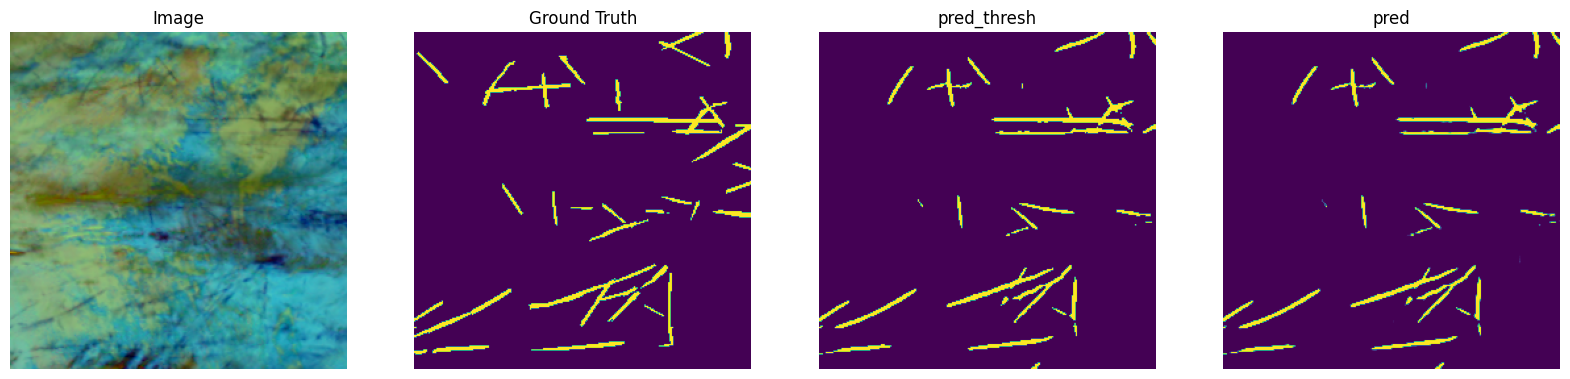

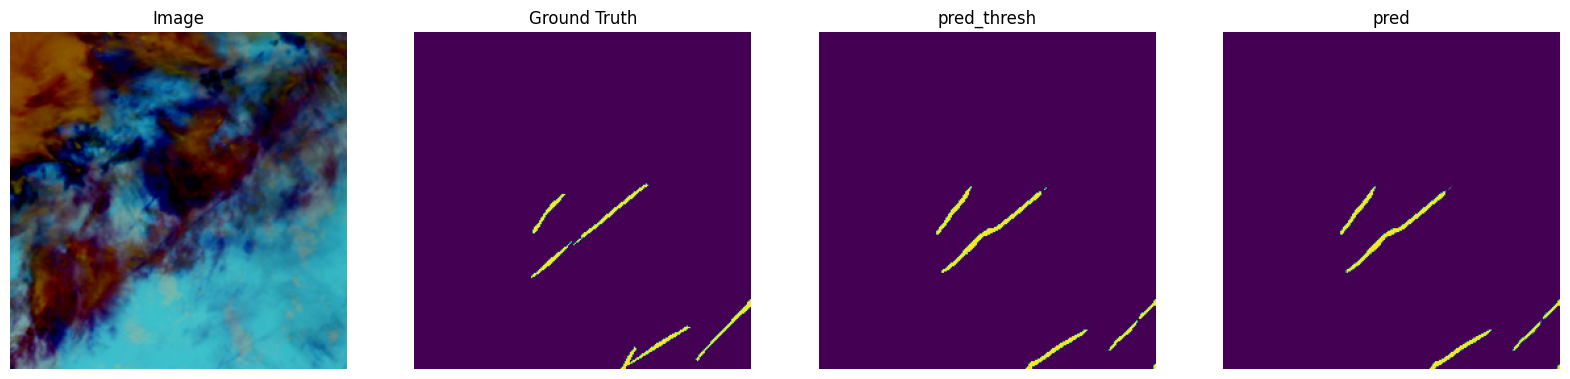

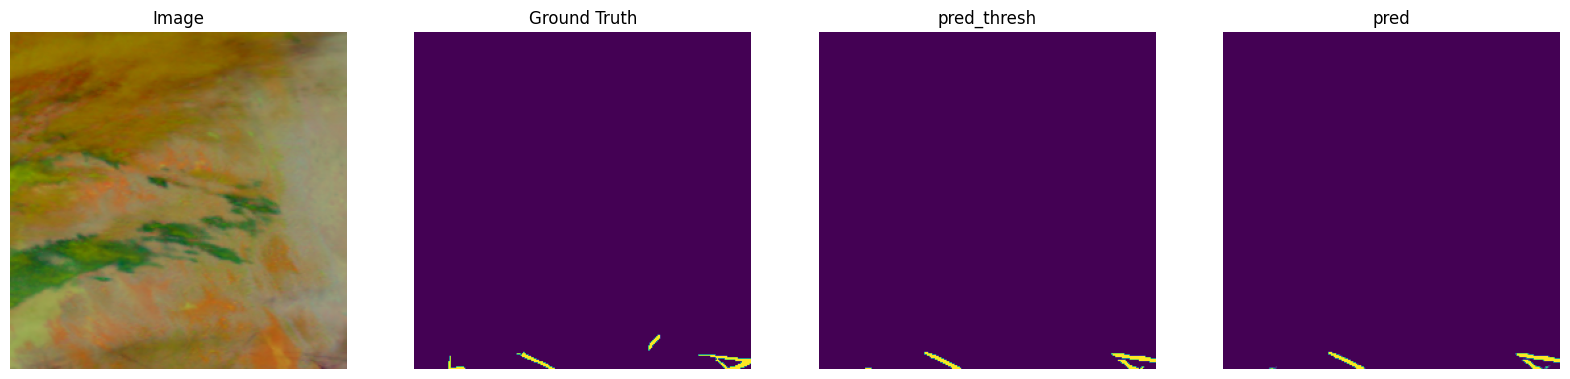

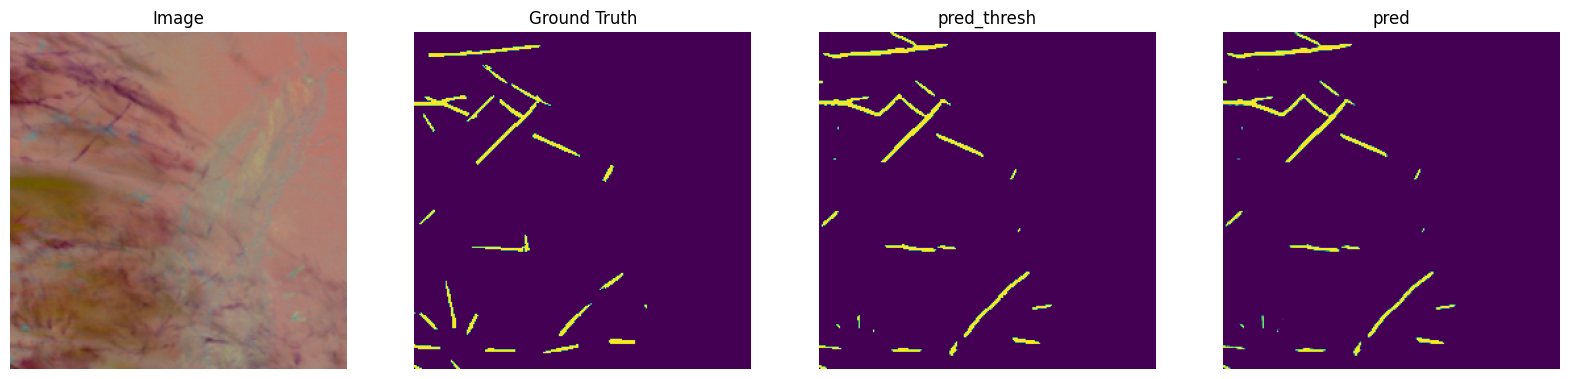

In [9]:
exp_name="model18"
for i, (images, masks) in enumerate(dataloader_valid):
    if i not in [5,6,7,8,9,10]: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        model, dice_score, thresh = load_model(f"/kaggle/working/notebook/experiment/v2/{exp_name}",exp_name)
        model.to(device)
        model.eval()       
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        if (masks[num].sum()==0) & ((preds[num]>thresh).sum()==0): continue
        if not (masks[num].sum()>100):continue
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow((preds[num]>thresh).permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred_thresh')
        axes[3].imshow(preds[num].permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred')

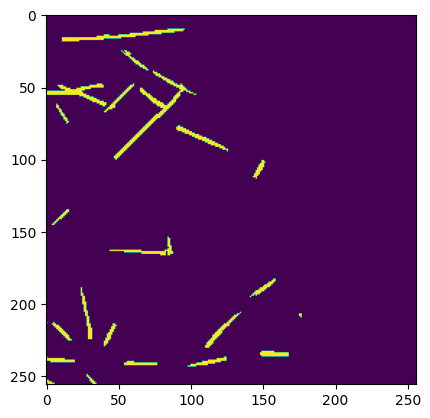

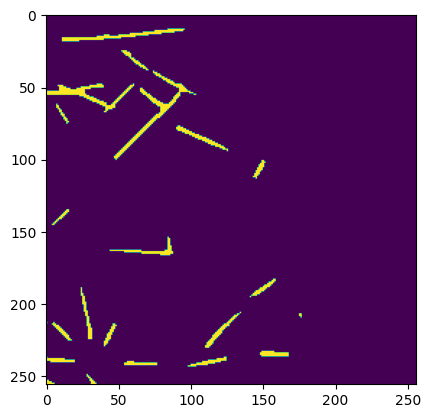

In [28]:

kernel = np.ones((3,3),np.uint8)
tmp_ = cv2.dilate(tmp,kernel,iterations = 1)
tmp_ = cv2.erode(tmp_,kernel,iterations = 1)
plt.figure()
plt.imshow(tmp)
plt.figure()
plt.imshow(tmp_)

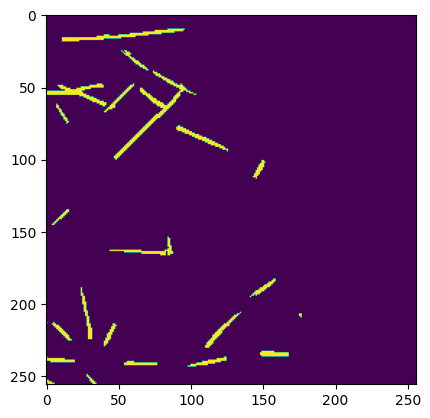